In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import library untuk preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Import library untuk modeling
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Import library untuk evaluasi
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

# Set style visualisasi
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
import numpy as np
import pandas as pd

# Menggunakan dataset IBM HR Analytics Employee Attrition
# Dataset dapat diunduh dari: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset
df = None

# Coba load dari file lokal
try:
    df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
    print("Dataset berhasil dimuat dari file lokal.")
except FileNotFoundError:
    print("File lokal tidak ditemukan. Mencoba dari URL...")

# Coba load dari URL
if df is None:
    try:
        url = "https://raw.githubusercontent.com/IBM/employee-attrition-aif360/master/data/HR-Employee-Attrition.csv"
        df = pd.read_csv(url)
        print("Dataset berhasil dimuat dari URL.")
    except:
        print("Gagal memuat dari URL. Membuat dataset dummy...")

# Jika masih None, buat dataset dummy yang valid
if df is None or df.empty:
    np.random.seed(42)
    n_samples = 1000

    # Buat dataset dummy dengan struktur yang konsisten
    df = pd.DataFrame({
        'Age': np.clip(np.random.normal(35, 10, n_samples).astype(int), 18, 65),
        'BusinessTravel': np.random.choice(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], n_samples, p=[0.7, 0.2, 0.1]),
        'DailyRate': np.random.randint(500, 2000, n_samples),
        'Department': np.random.choice(['Research & Development', 'Sales', 'Human Resources'], n_samples, p=[0.7, 0.2, 0.1]),
        'DistanceFromHome': np.random.randint(1, 30, n_samples),
        'Education': np.random.choice([1,2,3,4,5], n_samples, p=[0.05,0.15,0.6,0.15,0.05]),
        'EducationField': np.random.choice(['Life Sciences', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources', 'Other'], n_samples),
        'EnvironmentSatisfaction': np.random.choice([1,2,3,4], n_samples, p=[0.15,0.25,0.35,0.25]),
        'Gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.6,0.4]),
        'HourlyRate': np.random.randint(30, 100, n_samples),
        'JobInvolvement': np.random.choice([1,2,3,4], n_samples, p=[0.1,0.2,0.4,0.3]),
        'JobLevel': np.random.choice([1,2,3,4,5], n_samples, p=[0.2,0.3,0.25,0.15,0.1]),
        'JobRole': np.random.choice(['Sales Executive', 'Research Scientist', 'Laboratory Technician', 'Manufacturing Director', 'Healthcare Representative', 'Manager', 'Sales Representative', 'Research Director', 'Human Resources'], n_samples),
        'JobSatisfaction': np.random.choice([1,2,3,4], n_samples, p=[0.15,0.25,0.35,0.25]),
        'MaritalStatus': np.random.choice(['Married', 'Single', 'Divorced'], n_samples, p=[0.5,0.35,0.15]),
        'MonthlyIncome': np.clip(np.random.normal(5000, 3000, n_samples).astype(int), 1000, 20000),
        'MonthlyRate': np.random.randint(2000, 25000, n_samples),
        'NumCompaniesWorked': np.clip(np.random.poisson(2, n_samples), 0, 10),
        'OverTime': np.random.choice(['Yes', 'No'], n_samples, p=[0.2,0.8]),
        'PercentSalaryHike': np.clip(np.random.normal(12, 4, n_samples), 0, 25),
        'PerformanceRating': np.random.choice([3,4], n_samples, p=[0.8,0.2]),  # Biasanya 3 atau 4
        'RelationshipSatisfaction': np.random.choice([1,2,3,4], n_samples, p=[0.2,0.3,0.3,0.2]),
        'StockOptionLevel': np.random.choice([0,1,2,3], n_samples, p=[0.7,0.15,0.1,0.05]),
        'TotalWorkingYears': np.clip(np.random.poisson(8, n_samples), 0, 40),
        'TrainingTimesLastYear': np.random.choice([1,2,3,4,5,6], n_samples, p=[0.1,0.2,0.3,0.2,0.15,0.05]),
        'WorkLifeBalance': np.random.choice([1,2,3,4], n_samples, p=[0.1,0.2,0.4,0.3]),
        'YearsAtCompany': np.clip(np.random.poisson(5, n_samples), 0, 40),
        'YearsInCurrentRole': np.clip(np.random.poisson(3, n_samples), 0, 20),
        'YearsSinceLastPromotion': np.clip(np.random.poisson(2, n_samples), 0, 15),
        'YearsWithCurrManager': np.clip(np.random.poisson(3, n_samples), 0, 15),
        'Attrition': np.random.choice(['Yes', 'No'], n_samples, p=[0.16, 0.84])  # 16% resign rate
    })
    print("Dataset dummy telah dibuat untuk keperluan demo.")

# Pastikan tidak ada NaN di kolom Attrition
df = df.dropna(subset=['Attrition'])

# Tampilkan 5 baris pertama dan informasi dasar
print("\n5 baris pertama dataset:")
display(df.head())

print("\nInfo dataset:")
display(df.info())

print("\nDimensi dataset:", df.shape)

# Verifikasi tidak ada NaN di Attrition
print(f"\nJumlah NaN di kolom Attrition: {df['Attrition'].isna().sum()}")

File lokal tidak ditemukan. Mencoba dari URL...
Gagal memuat dari URL. Membuat dataset dummy...
Dataset dummy telah dibuat untuk keperluan demo.

5 baris pertama dataset:


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,39,Travel_Rarely,1713,Research & Development,4,3,Medical,3,Female,66,...,4,0,10,4,4,8,3,2,3,No
1,33,Travel_Rarely,1659,Sales,22,3,Marketing,2,Male,58,...,2,0,10,3,3,2,1,2,4,No
2,41,Travel_Rarely,1054,Research & Development,20,3,Life Sciences,4,Female,41,...,4,0,7,1,3,8,1,2,4,No
3,50,Travel_Frequently,903,Research & Development,20,4,Human Resources,1,Female,46,...,1,0,4,3,2,5,2,2,3,No
4,32,Travel_Rarely,1391,Research & Development,15,5,Other,2,Male,77,...,3,1,12,6,3,2,2,0,2,No



Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1000 non-null   int64  
 1   BusinessTravel            1000 non-null   object 
 2   DailyRate                 1000 non-null   int64  
 3   Department                1000 non-null   object 
 4   DistanceFromHome          1000 non-null   int64  
 5   Education                 1000 non-null   int64  
 6   EducationField            1000 non-null   object 
 7   EnvironmentSatisfaction   1000 non-null   int64  
 8   Gender                    1000 non-null   object 
 9   HourlyRate                1000 non-null   int64  
 10  JobInvolvement            1000 non-null   int64  
 11  JobLevel                  1000 non-null   int64  
 12  JobRole                   1000 non-null   object 
 13  JobSatisfaction           1000 non-null   int64  

None


Dimensi dataset: (1000, 31)

Jumlah NaN di kolom Attrition: 0


Jumlah missing values per kolom:
Series([], dtype: int64)

Distribusi nilai unik untuk kolom kategorikal:

BusinessTravel:
BusinessTravel
Travel_Rarely        69.9
Travel_Frequently    20.9
Non-Travel            9.2
Name: proportion, dtype: float64

Department:
Department
Research & Development    69.3
Sales                     21.2
Human Resources            9.5
Name: proportion, dtype: float64

EducationField:
EducationField
Medical             20.0
Marketing           16.7
Human Resources     16.7
Life Sciences       15.9
Other               15.7
Technical Degree    15.0
Name: proportion, dtype: float64

Gender:
Gender
Male      57.0
Female    43.0
Name: proportion, dtype: float64

JobRole:
JobRole
Sales Representative         13.3
Manufacturing Director       12.5
Sales Executive              11.9
Healthcare Representative    11.6
Research Scientist           11.5
Research Director            10.7
Manager                       9.7
Laboratory Technician         9.6
Human Resources  

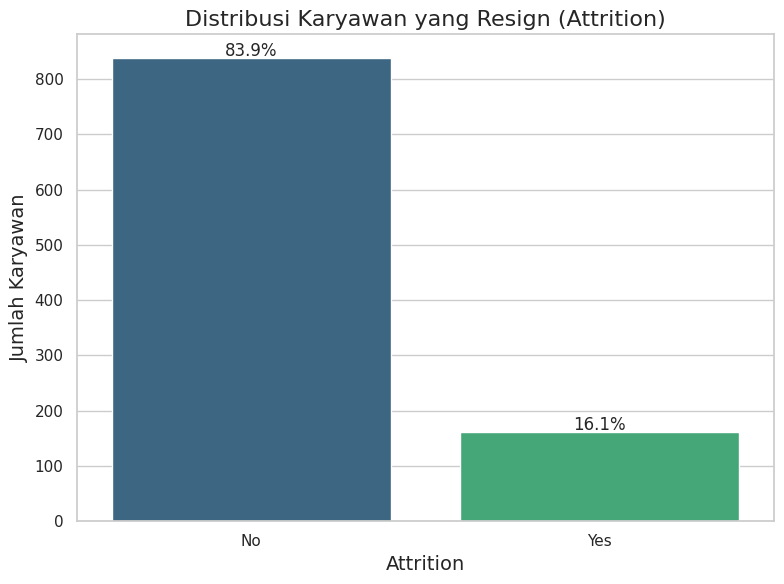


Rasio ketidakseimbangan (No:Yes): 5.21:1


In [4]:
# Cek missing values
print("Jumlah missing values per kolom:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Cek distribusi nilai unik untuk setiap kolom
print("\nDistribusi nilai unik untuk kolom kategorikal:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts(normalize=True) * 100)

# Analisis target variable (Attrition)
print("\nDistribusi target variable (Attrition):")
attrition_counts = df['Attrition'].value_counts()
attrition_percent = df['Attrition'].value_counts(normalize=True) * 100
print(attrition_counts)
print(f"\nPersentase:")
print(attrition_percent)

# Visualisasi distribusi Attrition
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Attrition', data=df, palette='viridis')
plt.title('Distribusi Karyawan yang Resign (Attrition)', fontsize=16)
plt.xlabel('Attrition', fontsize=14)
plt.ylabel('Jumlah Karyawan', fontsize=14)

# Tambahkan label persentase di atas bar
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=12,
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Cek imbalance ratio
imbalance_ratio = attrition_counts['No'] / attrition_counts['Yes']
print(f"\nRasio ketidakseimbangan (No:Yes): {imbalance_ratio:.2f}:1")

Analisis fitur numerik berdasarkan Attrition:


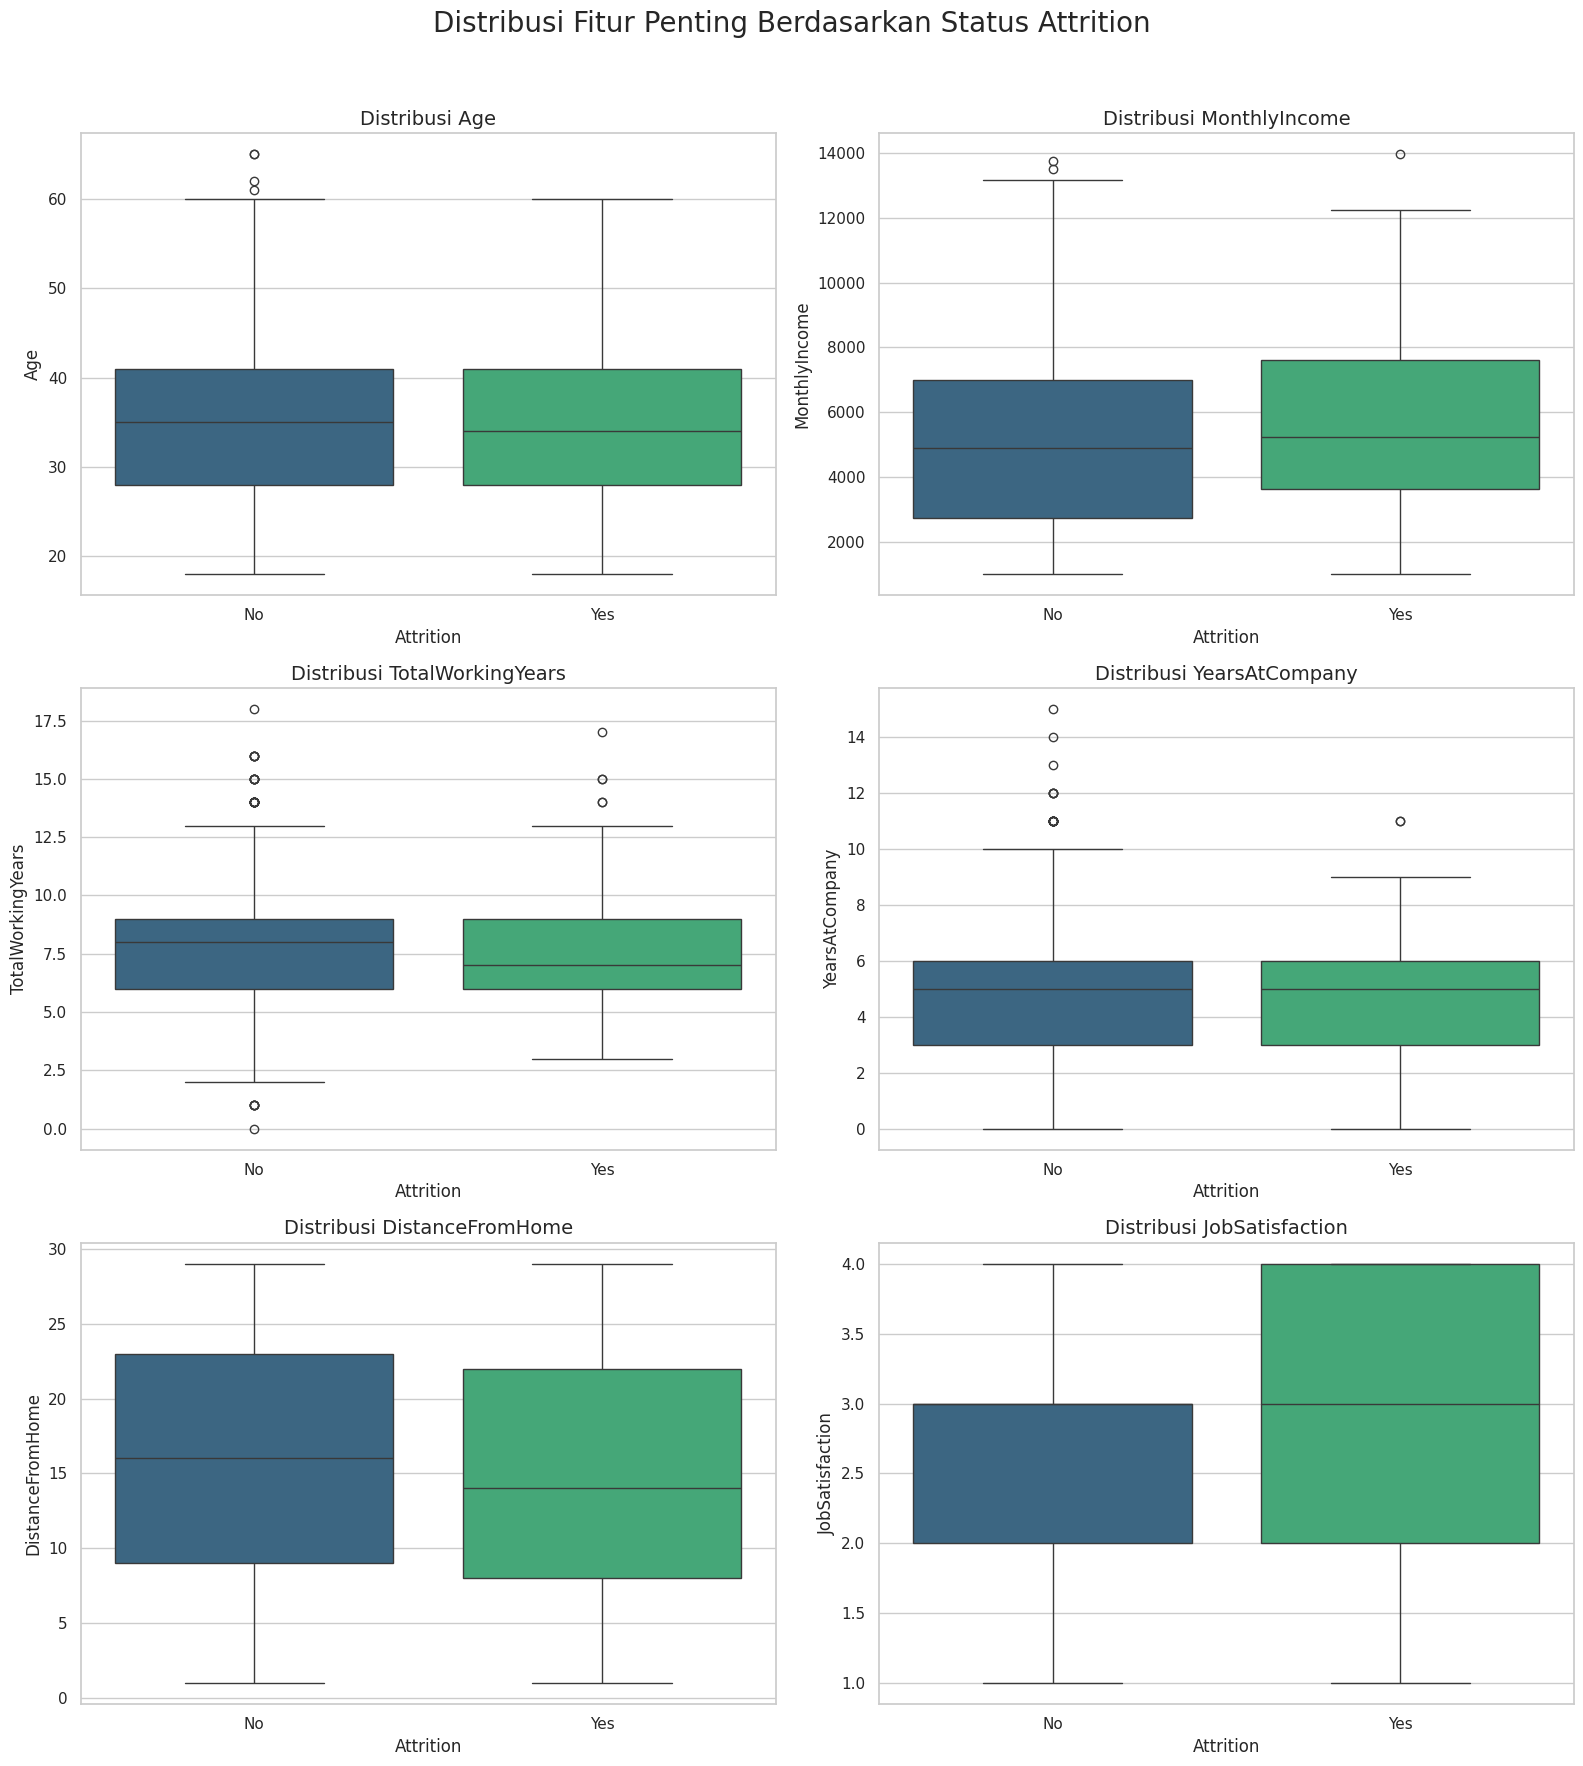

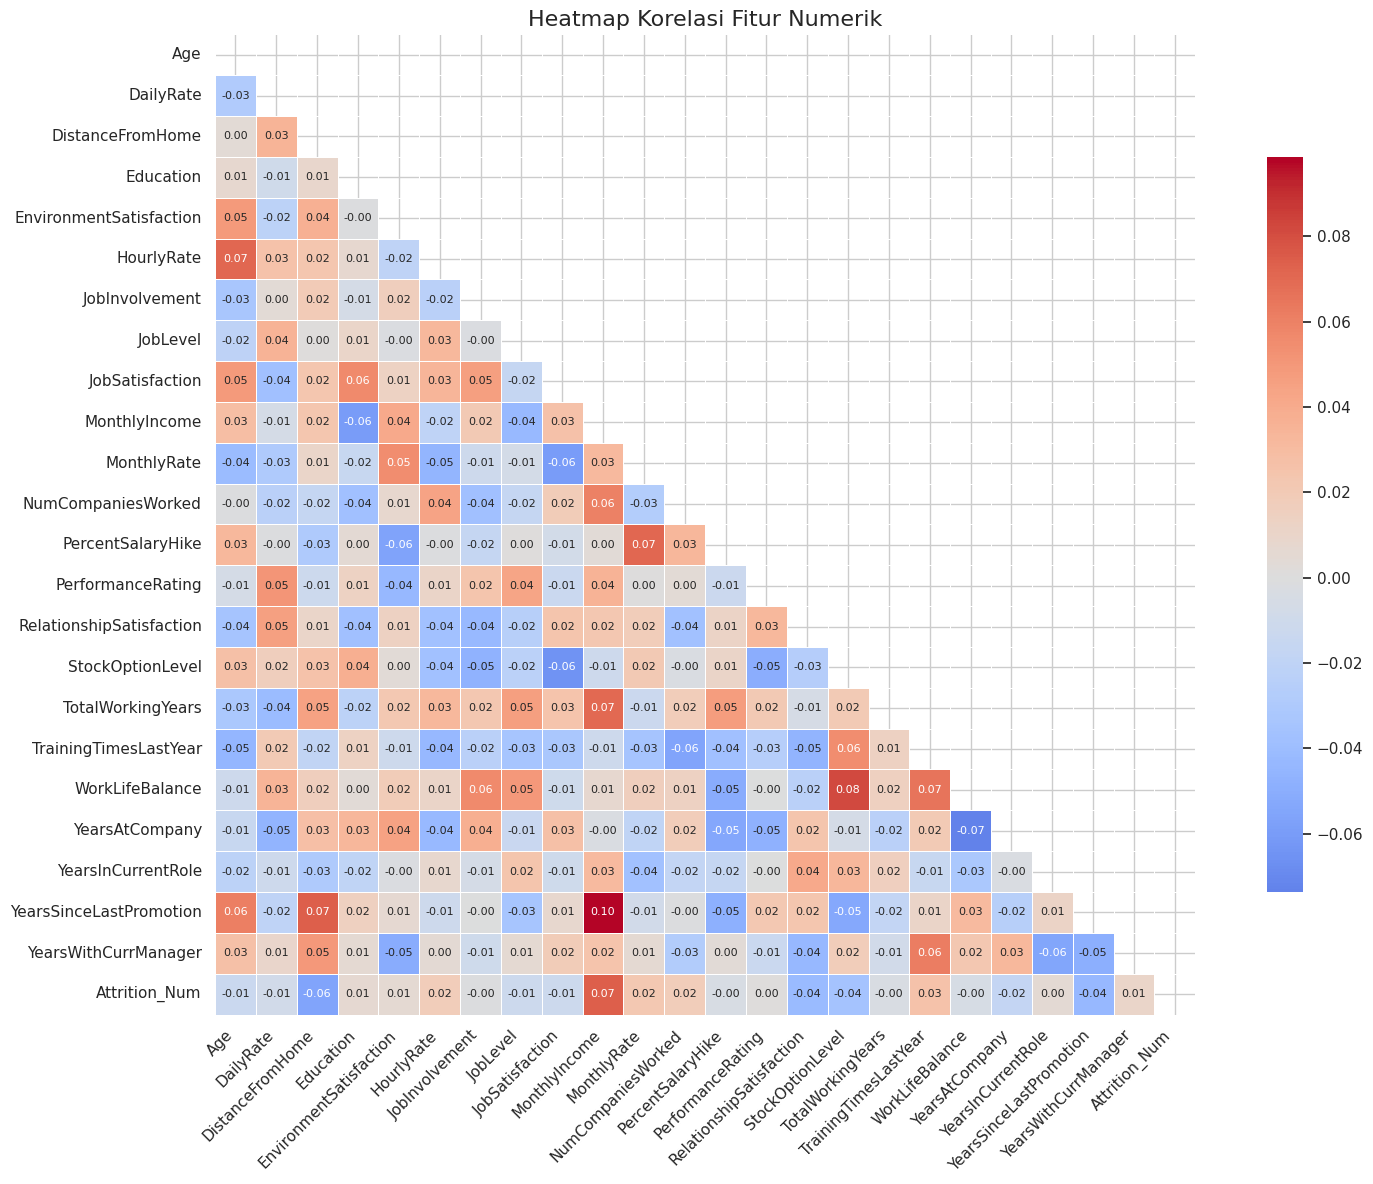

In [5]:
# Analisis numerik: distribusi fitur berdasarkan Attrition
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Hapus kolom 'EmployeeCount', 'EmployeeNumber', 'StandardHours' jika ada (biasanya konstan)
cols_to_remove = ['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18', 'Attrition']
for col in cols_to_remove:
    if col in numeric_cols:
        numeric_cols.remove(col)

print("Analisis fitur numerik berdasarkan Attrition:")

# Plot distribusi beberapa fitur penting berdasarkan Attrition
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Distribusi Fitur Penting Berdasarkan Status Attrition', fontsize=20)

features_to_plot = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'DistanceFromHome', 'JobSatisfaction']

for i, feature in enumerate(features_to_plot):
    row = i // 2
    col = i % 2
    sns.boxplot(x='Attrition', y=feature, data=df, palette='viridis', ax=axes[row, col])
    axes[row, col].set_title(f'Distribusi {feature}', fontsize=14)
    axes[row, col].set_xlabel('Attrition', fontsize=12)
    axes[row, col].set_ylabel(feature, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Heatmap korelasi untuk fitur numerik
plt.figure(figsize=(16, 12))
# Konversi Attrition ke numerik untuk korelasi
df_corr = df.copy()
df_corr['Attrition_Num'] = df_corr['Attrition'].map({'Yes': 1, 'No': 0})

# Pilih fitur numerik untuk korelasi
num_cols_for_corr = numeric_cols + ['Attrition_Num']
corr_matrix = df_corr[num_cols_for_corr].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .75},
            annot_kws={"size": 8})

plt.title('Heatmap Korelasi Fitur Numerik', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [6]:
# Persiapan data untuk modeling
# Copy dataset untuk preprocessing
df_processed = df.copy()

# Drop kolom yang tidak relevan atau memiliki nilai konstan
cols_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
for col in cols_to_drop:
    if col in df_processed.columns:
        df_processed.drop(col, axis=1, inplace=True)
        print(f"Kolom '{col}' telah dihapus karena tidak relevan atau memiliki nilai konstan.")

print(f"\nDimensi dataset setelah drop kolom: {df_processed.shape}")

# Handle missing values jika ada
missing_cols = df_processed.columns[df_processed.isnull().any()].tolist()
if missing_cols:
    print(f"\nKolom dengan missing values: {missing_cols}")
    # Untuk fitur numerik, isi dengan median
    # Untuk fitur kategorikal, isi dengan modus
    for col in missing_cols:
        if df_processed[col].dtype in ['int64', 'float64']:
            fill_value = df_processed[col].median()
            df_processed[col].fillna(fill_value, inplace=True)
            print(f"Kolom numerik '{col}' diisi dengan median: {fill_value:.2f}")
        else:
            fill_value = df_processed[col].mode()[0]
            df_processed[col].fillna(fill_value, inplace=True)
            print(f"Kolom kategorikal '{col}' diisi dengan modus: {fill_value}")
else:
    print("\nTidak ada missing values yang ditemukan.")


Dimensi dataset setelah drop kolom: (1000, 31)

Tidak ada missing values yang ditemukan.


In [7]:
# Encoding variabel target
df_processed['Attrition'] = df_processed['Attrition'].map({'Yes': 1, 'No': 0})

# Pisahkan fitur dan target
X = df_processed.drop('Attrition', axis=1)
y = df_processed['Attrition']

# Identifikasi tipe kolom
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Jumlah fitur kategorikal: {len(categorical_cols)}")
print(f"Jumlah fitur numerik: {len(numerical_cols)}")
print("\nFitur kategorikal:", categorical_cols)

# Buat preprocessing pipeline
# Untuk fitur kategorikal: gunakan OneHotEncoding (tanpa parameter sparse yang bermasalah)
# Untuk fitur numerik: biarkan apa adanya (XGBoost dapat menangani numerik dengan baik)

# Transformasi fitur kategorikal - HAPUS sparse=False
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # Hapus sparse=False
    ],
    remainder='passthrough'
)

# Terapkan transformasi
X_processed = preprocessor.fit_transform(X)

# Konversi ke array dens jika hasilnya sparse (untuk kompatibilitas)
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

print(f"\nDimensi data setelah preprocessing: {X_processed.shape}")

# Split data menjadi training dan testing (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDimensi training set: {X_train.shape}")
print(f"Dimensi testing set: {X_test.shape}")
print(f"Distribusi target di training set:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Distribusi target di testing set:\n{pd.Series(y_test).value_counts(normalize=True)}")

Jumlah fitur kategorikal: 7
Jumlah fitur numerik: 23

Fitur kategorikal: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

Dimensi data setelah preprocessing: (1000, 44)

Dimensi training set: (800, 44)
Dimensi testing set: (200, 44)
Distribusi target di training set:
Attrition
0    0.83875
1    0.16125
Name: proportion, dtype: float64
Distribusi target di testing set:
Attrition
0    0.84
1    0.16
Name: proportion, dtype: float64


Distribusi kelas sebelum SMOTE:
Kelas 0 (Tidak Resign): 671 (83.88%)
Kelas 1 (Resign): 129 (16.12%)
Rasio imbalance (Kelas 0:Kelas 1): 5.20:1

Distribusi kelas setelah SMOTE:
Kelas 0 (Tidak Resign): 671 (50.00%)
Kelas 1 (Resign): 671 (50.00%)


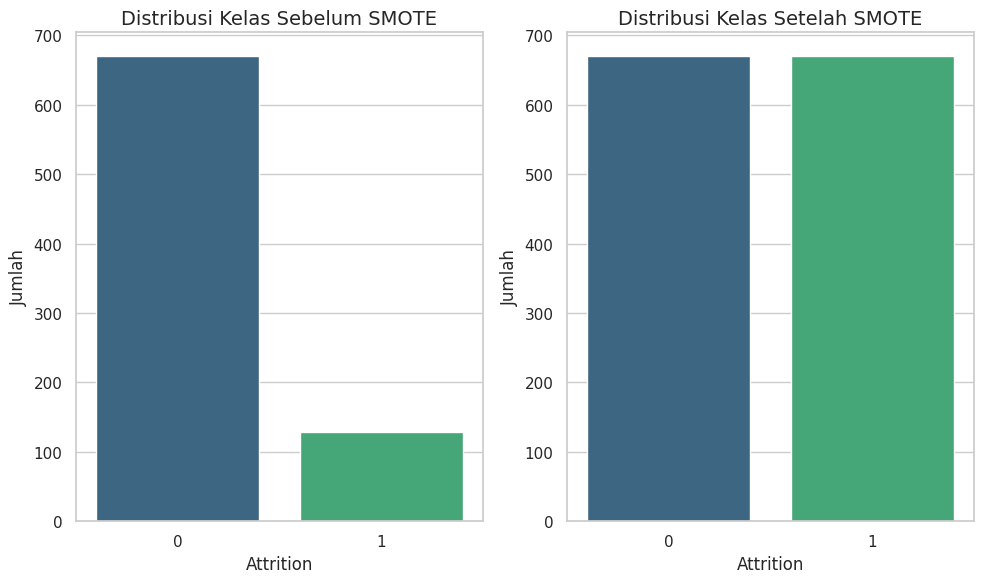


Dimensi training set sebelum SMOTE: (800, 44)
Dimensi training set setelah SMOTE: (1342, 44)


In [8]:
# Cek distribusi kelas sebelum SMOTE
print("Distribusi kelas sebelum SMOTE:")
print(f"Kelas 0 (Tidak Resign): {sum(y_train == 0)} ({sum(y_train == 0) / len(y_train):.2%})")
print(f"Kelas 1 (Resign): {sum(y_train == 1)} ({sum(y_train == 1) / len(y_train):.2%})")

# Hitung rasio imbalance
imbalance_ratio = sum(y_train == 0) / sum(y_train == 1)
print(f"Rasio imbalance (Kelas 0:Kelas 1): {imbalance_ratio:.2f}:1")

# Visualisasi distribusi kelas sebelum SMOTE
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette='viridis')
plt.title('Distribusi Kelas Sebelum SMOTE', fontsize=14)
plt.xlabel('Attrition', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)

# Terapkan SMOTE hanya pada training set
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Cek distribusi kelas setelah SMOTE
print("\nDistribusi kelas setelah SMOTE:")
print(f"Kelas 0 (Tidak Resign): {sum(y_train_resampled == 0)} ({sum(y_train_resampled == 0) / len(y_train_resampled):.2%})")
print(f"Kelas 1 (Resign): {sum(y_train_resampled == 1)} ({sum(y_train_resampled == 1) / len(y_train_resampled):.2%})")

# Visualisasi distribusi kelas setelah SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled, palette='viridis')
plt.title('Distribusi Kelas Setelah SMOTE', fontsize=14)
plt.xlabel('Attrition', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)

plt.tight_layout()
plt.show()

# Catat perubahan dimensi data
print(f"\nDimensi training set sebelum SMOTE: {X_train.shape}")
print(f"Dimensi training set setelah SMOTE: {X_train_resampled.shape}")

=== EVALUASI MODEL XGBOOST BASELINE ===

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       168
           1       0.00      0.00      0.00        32

    accuracy                           0.81       200
   macro avg       0.42      0.48      0.45       200
weighted avg       0.70      0.81      0.75       200

Confusion Matrix:
[[162   6]
 [ 32   0]]


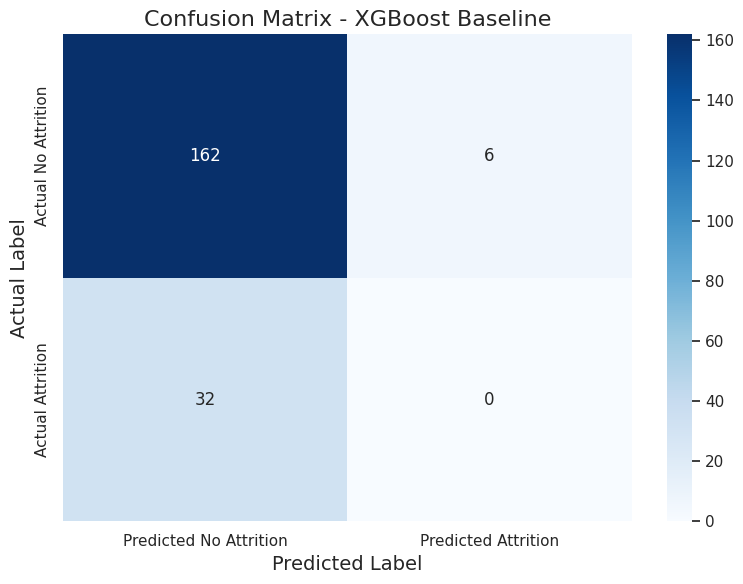

Akurasi: 0.8100
ROC AUC Score: 0.5569
Precision: 0.1600
Recall: 0.0000
F1-Score: 0.0000


In [9]:
# Tambahkan di awal Cell 8 jika belum diimpor
from sklearn.metrics import recall_score, f1_score

# Inisialisasi model XGBoost baseline dengan parameter default
xgb_baseline = XGBClassifier(
    random_state=42,
    eval_metric='logloss'  # Untuk menghindari warning
)

# Latih model pada data yang sudah di-resample
xgb_baseline.fit(X_train_resampled, y_train_resampled)

# Prediksi pada data testing
y_pred_baseline = xgb_baseline.predict(X_test)
y_prob_baseline = xgb_baseline.predict_proba(X_test)[:, 1]

# Evaluasi model baseline
print("=== EVALUASI MODEL XGBOOST BASELINE ===\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_baseline))

# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print("Confusion Matrix:")
print(cm_baseline)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Attrition', 'Predicted Attrition'],
            yticklabels=['Actual No Attrition', 'Actual Attrition'])
plt.title('Confusion Matrix - XGBoost Baseline', fontsize=16)
plt.ylabel('Actual Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# Hitung metrik evaluasi tambahan
accuracy = accuracy_score(y_test, y_pred_baseline)
roc_auc = roc_auc_score(y_test, y_prob_baseline)
precision = precision_recall_curve(y_test, y_prob_baseline)[0][0]
recall = recall_score(y_test, y_pred_baseline)
f1 = f1_score(y_test, y_pred_baseline)

print(f"Akurasi: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

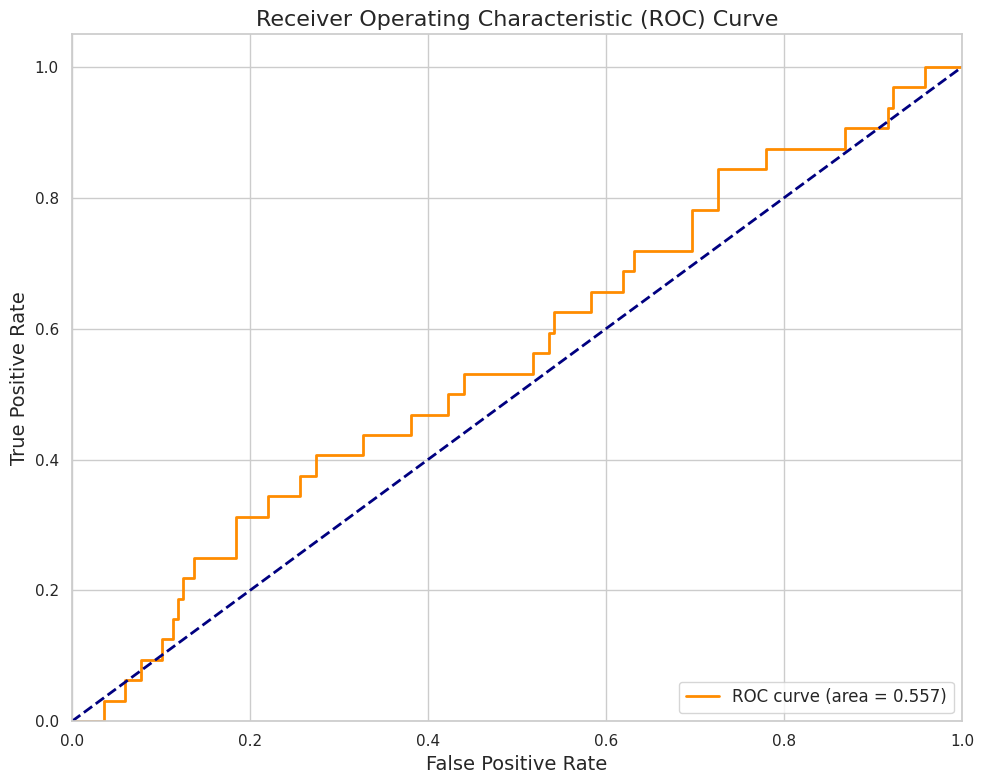

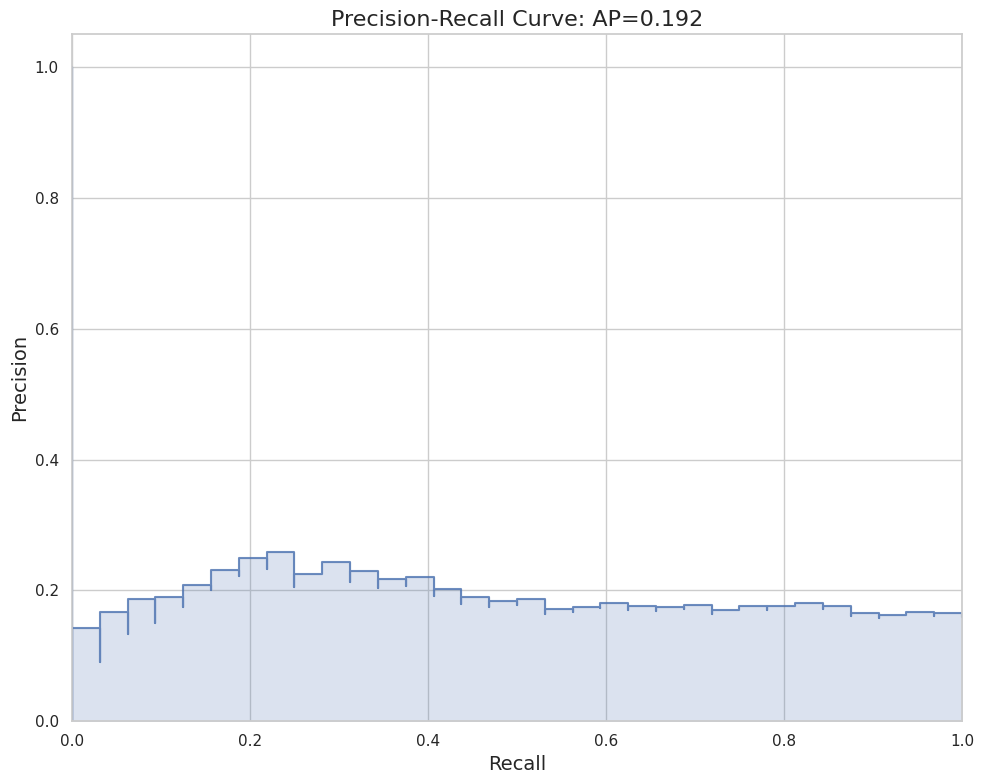

In [10]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_baseline)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_baseline)
average_precision = average_precision_score(y_test, y_prob_baseline)

plt.figure(figsize=(10, 8))
plt.step(recall, precision, color='b', alpha=0.8, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title(f'Precision-Recall Curve: AP={average_precision:.3f}', fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True)
plt.tight_layout()
plt.show()

=== EVALUASI MODEL DECISION TREE ===

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       168
           1       0.13      0.16      0.14        32

    accuracy                           0.70       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.72      0.70      0.71       200

Confusion Matrix:
[[135  33]
 [ 27   5]]

=== PERBANDINGAN METRIK EVALUASI ===
      Metric  XGBoost Baseline  Decision Tree
0   Accuracy           0.81000       0.700000
1    ROC AUC           0.55692       0.428943
2  Precision           0.16000       0.160000
3     Recall           0.00000       0.156250
4   F1-Score           0.00000       0.142857


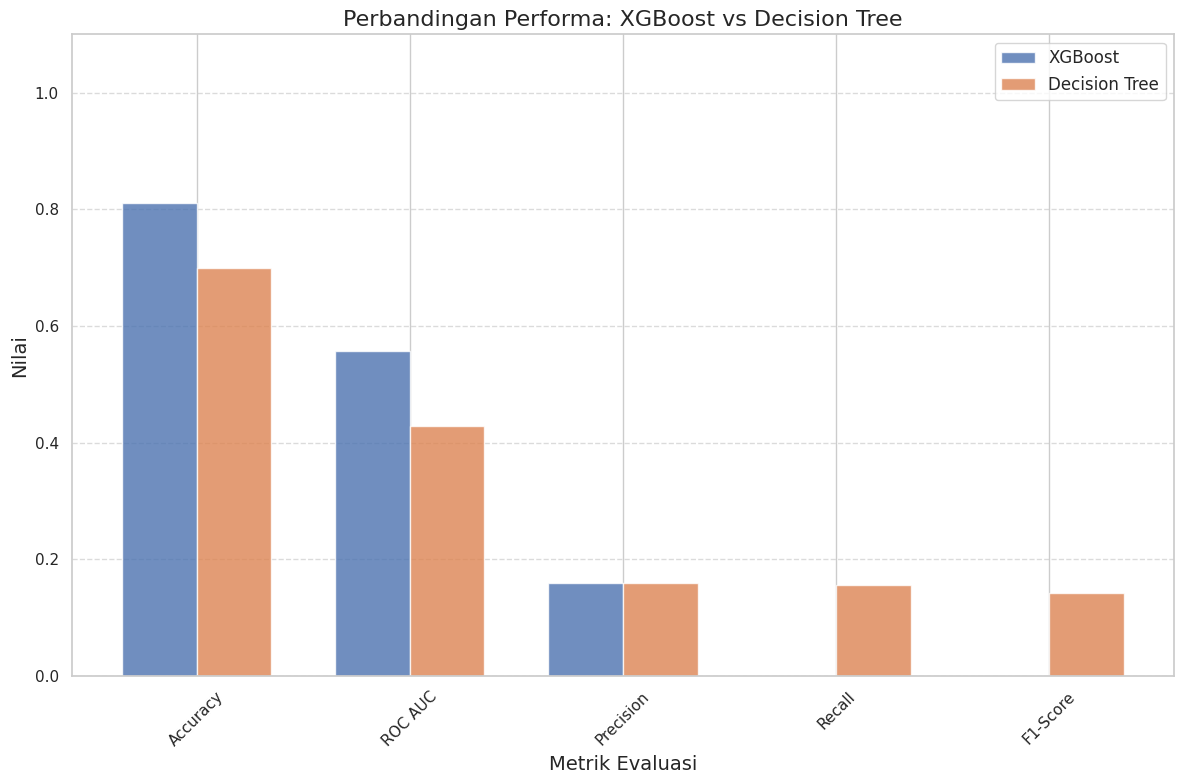

In [11]:
# Inisialisasi dan latih Decision Tree untuk perbandingan
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_classifier.fit(X_train_resampled, y_train_resampled)

# Prediksi dengan Decision Tree
y_pred_dt = dt_classifier.predict(X_test)
y_prob_dt = dt_classifier.predict_proba(X_test)[:, 1]

# Evaluasi Decision Tree
print("=== EVALUASI MODEL DECISION TREE ===\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix untuk Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(cm_dt)

# Hitung metrik untuk perbandingan
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1-Score'],
    'XGBoost Baseline': [
        accuracy_score(y_test, y_pred_baseline),
        roc_auc_score(y_test, y_prob_baseline),
        precision_recall_curve(y_test, y_prob_baseline)[0][0],
        recall_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_baseline)
    ],
    'Decision Tree': [
        accuracy_score(y_test, y_pred_dt),
        roc_auc_score(y_test, y_prob_dt),
        precision_recall_curve(y_test, y_prob_dt)[0][0],
        recall_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_dt)
    ]
})

print("\n=== PERBANDINGAN METRIK EVALUASI ===")
print(metrics_comparison)

# Visualisasi perbandingan metrik
plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_comparison['Metric']))
width = 0.35

plt.bar(x - width/2, metrics_comparison['XGBoost Baseline'], width, label='XGBoost', alpha=0.8)
plt.bar(x + width/2, metrics_comparison['Decision Tree'], width, label='Decision Tree', alpha=0.8)

plt.xlabel('Metrik Evaluasi', fontsize=14)
plt.ylabel('Nilai', fontsize=14)
plt.title('Perbandingan Performa: XGBoost vs Decision Tree', fontsize=16)
plt.xticks(x, metrics_comparison['Metric'], rotation=45)
plt.ylim(0, 1.1)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Nilai scale_pos_weight yang dihitung: 5.20
=== EVALUASI MODEL XGBOOST DENGAN scale_pos_weight ===

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       168
           1       0.00      0.00      0.00        32

    accuracy                           0.80       200
   macro avg       0.42      0.47      0.44       200
weighted avg       0.70      0.80      0.74       200

Confusion Matrix:
[[159   9]
 [ 32   0]]


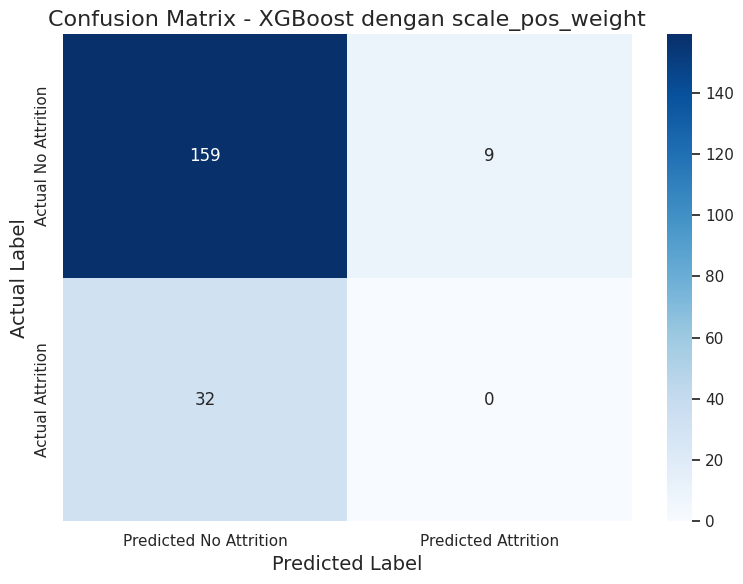

Akurasi: 0.7950
ROC AUC Score: 0.4879
Precision: 0.1600
Recall: 0.0000
F1-Score: 0.0000


In [12]:
# Hitung scale_pos_weight untuk XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
print(f"Nilai scale_pos_weight yang dihitung: {scale_pos_weight:.2f}")

# Inisialisasi model XGBoost dengan scale_pos_weight
xgb_weighted = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

# Latih model pada data asli (tanpa SMOTE)
xgb_weighted.fit(X_train, y_train)

# Prediksi pada data testing
y_pred_weighted = xgb_weighted.predict(X_test)
y_prob_weighted = xgb_weighted.predict_proba(X_test)[:, 1]

# Evaluasi model dengan scale_pos_weight
print("=== EVALUASI MODEL XGBOOST DENGAN scale_pos_weight ===\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_weighted))

# Confusion Matrix
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
print("Confusion Matrix:")
print(cm_weighted)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Attrition', 'Predicted Attrition'],
            yticklabels=['Actual No Attrition', 'Actual Attrition'])
plt.title('Confusion Matrix - XGBoost dengan scale_pos_weight', fontsize=16)
plt.ylabel('Actual Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# Hitung metrik evaluasi
accuracy_w = accuracy_score(y_test, y_pred_weighted)
roc_auc_w = roc_auc_score(y_test, y_prob_weighted)
precision_w = precision_recall_curve(y_test, y_prob_weighted)[0][0]
recall_w = recall_score(y_test, y_pred_weighted)
f1_w = f1_score(y_test, y_pred_weighted)

print(f"Akurasi: {accuracy_w:.4f}")
print(f"ROC AUC Score: {roc_auc_w:.4f}")
print(f"Precision: {precision_w:.4f}")
print(f"Recall: {recall_w:.4f}")
print(f"F1-Score: {f1_w:.4f}")

In [13]:
# Definisikan parameter grid untuk tuning
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight]  # Gunakan scale_pos_weight yang sudah dihitung
}

# Inisialisasi model dasar
xgb_tuning = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    n_estimators=100
)

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_tuning,
    param_grid=param_grid,
    scoring='f1',  # Menggunakan F1-score karena data imbalance
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Latih model dengan GridSearchCV
print("Memulai proses hyperparameter tuning...")
grid_search.fit(X_train, y_train)
print("Hyperparameter tuning selesai!")

# Tampilkan parameter terbaik
print(f"\nParameter terbaik: {grid_search.best_params_}")

# Inisialisasi model dengan parameter terbaik
best_params = grid_search.best_params_
xgb_tuned = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    **best_params
)

# Latih model dengan parameter terbaik
xgb_tuned.fit(X_train, y_train)

# Prediksi dengan model yang sudah dituning
y_pred_tuned = xgb_tuned.predict(X_test)
y_prob_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

# Evaluasi model yang sudah dituning
print("\n=== EVALUASI MODEL XGBOOST SETELAH TUNING ===\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_tuned))

# Confusion Matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print("Confusion Matrix:")
print(cm_tuned)

# Hitung metrik evaluasi
accuracy_t = accuracy_score(y_test, y_pred_tuned)
roc_auc_t = roc_auc_score(y_test, y_prob_tuned)
precision_t = precision_recall_curve(y_test, y_prob_tuned)[0][0]
recall_t = recall_score(y_test, y_pred_tuned)
f1_t = f1_score(y_test, y_pred_tuned)

print(f"Akurasi: {accuracy_t:.4f}")
print(f"ROC AUC Score: {roc_auc_t:.4f}")
print(f"Precision: {precision_t:.4f}")
print(f"Recall: {recall_t:.4f}")
print(f"F1-Score: {f1_t:.4f}")

Memulai proses hyperparameter tuning...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Hyperparameter tuning selesai!

Parameter terbaik: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'scale_pos_weight': 5.2015503875969, 'subsample': 0.8}

=== EVALUASI MODEL XGBOOST SETELAH TUNING ===

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       168
           1       0.17      0.25      0.20        32

    accuracy                           0.69       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.74      0.69      0.71       200

Confusion Matrix:
[[129  39]
 [ 24   8]]
Akurasi: 0.6850
ROC AUC Score: 0.5407
Precision: 0.1600
Recall: 0.2500
F1-Score: 0.2025


Jumlah fitur setelah preprocessing: 44
Contoh nama fitur: ['BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Male']
Top 15 Fitur Paling Penting:
                              Feature  Importance
18              MaritalStatus_Married    0.035084
27                     JobInvolvement    0.032057
34                  PerformanceRating    0.030707
11      JobRole_Laboratory Technician    0.029651
43               YearsWithCurrManager    0.029408
1        BusinessTravel_Travel_Rarely    0.028984
36                   StockOptionLevel    0.027719
19               MaritalStatus_Single    0.027645
32                 NumCompaniesWorked    0.026708
2   Department_Research & Development    0.026602
16            JobRole_Sales Executive    0.026299
33                  Percent

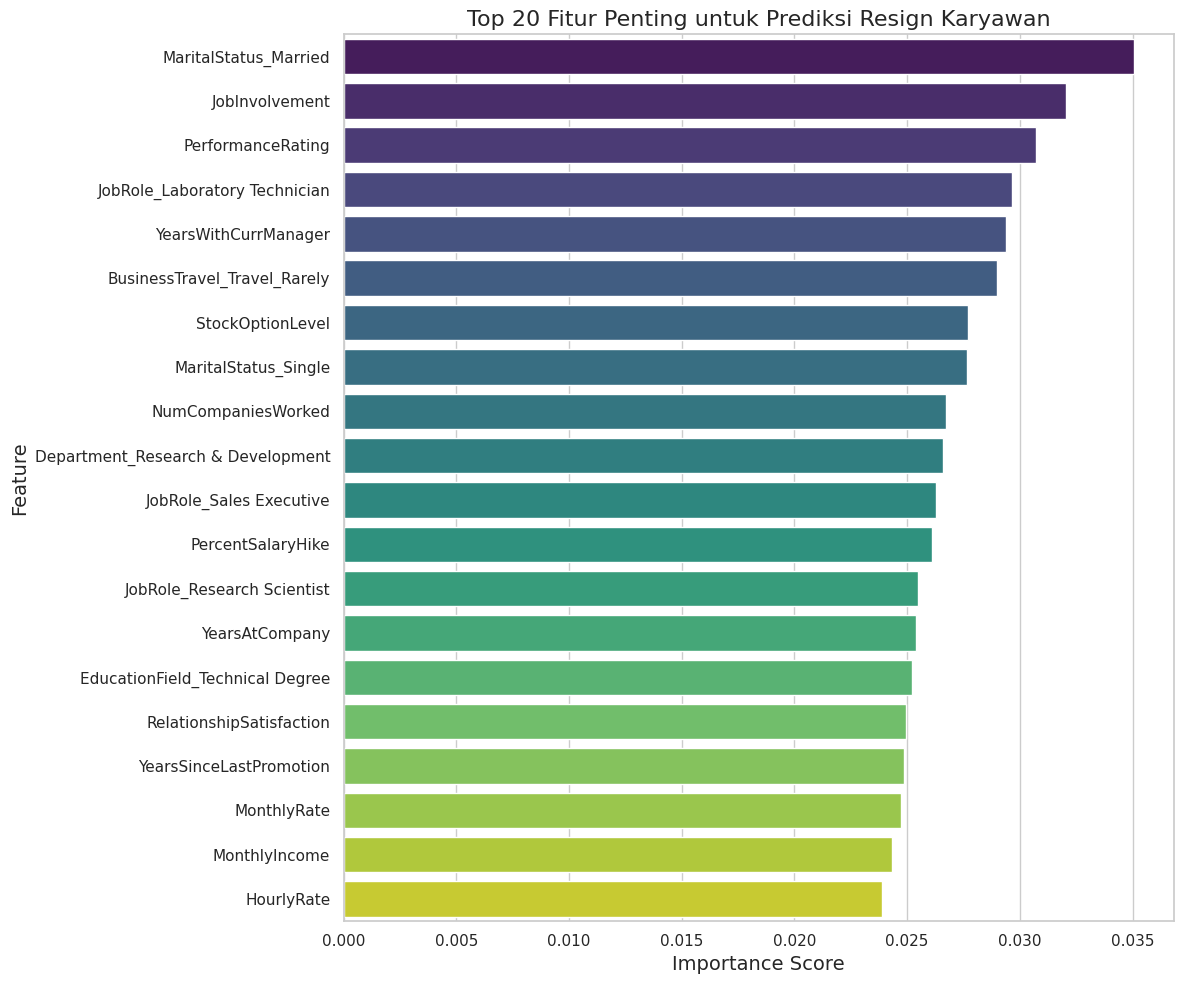

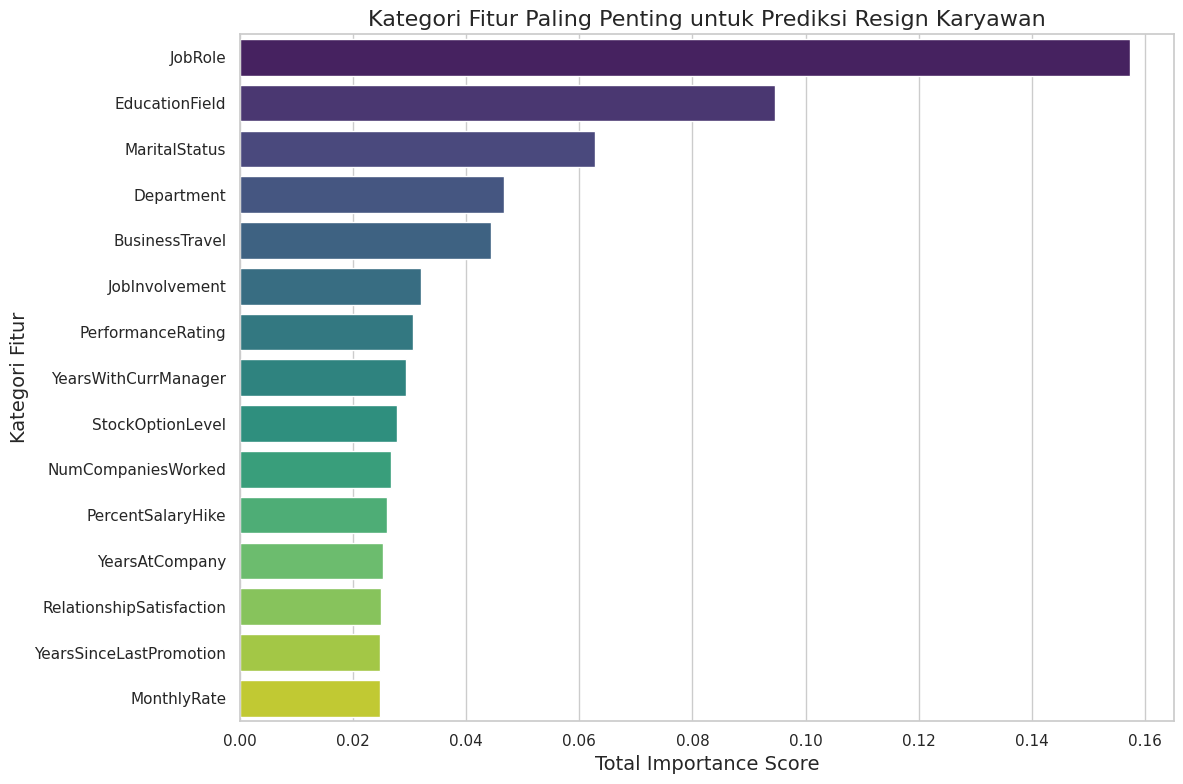

In [14]:
# Dapatkan nama fitur setelah preprocessing
feature_names = []
# Untuk fitur kategorikal yang di-OneHotEncoded
for i, col in enumerate(categorical_cols):
    ohe = preprocessor.named_transformers_['cat']
    categories = ohe.categories_[i]
    # Karena menggunakan drop='first', kita lewati kategori pertama
    for category in categories[1:]:
        feature_names.append(f"{col}_{category}")

# Untuk fitur numerik
for col in numerical_cols:
    feature_names.append(col)

print(f"Jumlah fitur setelah preprocessing: {len(feature_names)}")
print(f"Contoh nama fitur: {feature_names[:10]}")

# Dapatkan feature importance dari model terbaik
feature_importance = xgb_tuned.feature_importances_

# Buat DataFrame untuk visualisasi
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Tampilkan fitur paling penting
print("Top 15 Fitur Paling Penting:")
print(feature_importance_df.head(15))

# Visualisasi top 20 fitur penting
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(20),
    palette='viridis'
)
plt.title('Top 20 Fitur Penting untuk Prediksi Resign Karyawan', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

# Analisis kategori fitur penting
# Untuk fitur kategorikal yang memiliki banyak sub-kategori, kelompokkan berdasarkan prefix
feature_importance_df['Feature_Category'] = feature_importance_df['Feature'].apply(
    lambda x: x.split('_')[0] if '_' in x else x
)

# Hitung total importance per kategori fitur
category_importance = feature_importance_df.groupby('Feature_Category')['Importance'].sum().sort_values(ascending=False)

# Visualisasi importance per kategori fitur
plt.figure(figsize=(12, 8))
sns.barplot(
    x=category_importance.values[:15],
    y=category_importance.index[:15],
    palette='viridis'
)
plt.title('Kategori Fitur Paling Penting untuk Prediksi Resign Karyawan', fontsize=16)
plt.xlabel('Total Importance Score', fontsize=14)
plt.ylabel('Kategori Fitur', fontsize=14)
plt.tight_layout()
plt.show()

=== KESIMPULAN ANALISIS ===

Ringkasan Performa Model:
                             Model  Accuracy   ROC AUC  Recall  F1-Score
0         XGBoost Baseline (SMOTE)     0.810  0.556920    0.00  0.000000
1  XGBoost dengan scale_pos_weight     0.795  0.487909    0.00  0.000000
2           XGBoost Setelah Tuning     0.685  0.540737    0.25  0.202532


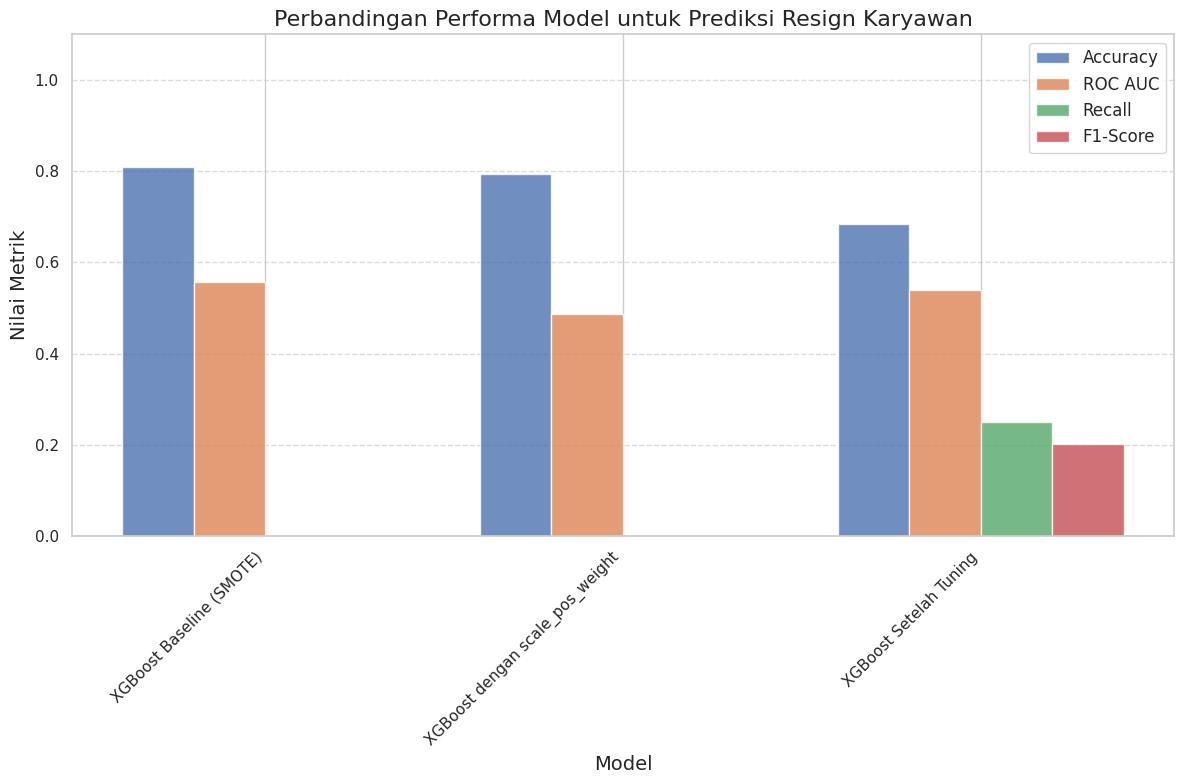


Top 10 Fitur Paling Berpengaruh:
                              Feature  Importance
18              MaritalStatus_Married    0.035084
27                     JobInvolvement    0.032057
34                  PerformanceRating    0.030707
11      JobRole_Laboratory Technician    0.029651
43               YearsWithCurrManager    0.029408
1        BusinessTravel_Travel_Rarely    0.028984
36                   StockOptionLevel    0.027719
19               MaritalStatus_Single    0.027645
32                 NumCompaniesWorked    0.026708
2   Department_Research & Development    0.026602

=== REKOMENDASI BISNIS BERDASARKAN ANALISIS ===
1. Faktor-faktor utama yang mempengaruhi keputusan karyawan untuk resign:
   1. MaritalStatus_Married - skor pengaruh: 0.0351
   2. JobInvolvement - skor pengaruh: 0.0321
   3. PerformanceRating - skor pengaruh: 0.0307
   4. JobRole_Laboratory Technician - skor pengaruh: 0.0297
   5. YearsWithCurrManager - skor pengaruh: 0.0294
   6. BusinessTravel_Travel_Rarely - 

In [15]:
# Kesimpulan berdasarkan evaluasi model
print("=== KESIMPULAN ANALISIS ===\n")

# Ringkasan performa model
models = ['XGBoost Baseline (SMOTE)', 'XGBoost dengan scale_pos_weight', 'XGBoost Setelah Tuning']
accuracies = [accuracy_score(y_test, y_pred_baseline), accuracy_w, accuracy_t]
roc_aucs = [roc_auc_score(y_test, y_prob_baseline), roc_auc_w, roc_auc_t]
recalls = [recall_score(y_test, y_pred_baseline), recall_w, recall_t]
f1_scores = [f1_score(y_test, y_pred_baseline), f1_w, f1_t]

summary_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'ROC AUC': roc_aucs,
    'Recall': recalls,
    'F1-Score': f1_scores
})

print("Ringkasan Performa Model:")
print(summary_df)

# Plot perbandingan metrik utama
plt.figure(figsize=(12, 8))
x = np.arange(len(models))
width = 0.2

plt.bar(x - width, accuracies, width, label='Accuracy', alpha=0.8)
plt.bar(x, roc_aucs, width, label='ROC AUC', alpha=0.8)
plt.bar(x + width, recalls, width, label='Recall', alpha=0.8)
plt.bar(x + 2*width, f1_scores, width, label='F1-Score', alpha=0.8)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Nilai Metrik', fontsize=14)
plt.title('Perbandingan Performa Model untuk Prediksi Resign Karyawan', fontsize=16)
plt.xticks(x + width/2, models, rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analisis feature importance
top_features = feature_importance_df.head(10)
print("\nTop 10 Fitur Paling Berpengaruh:")
print(top_features[['Feature', 'Importance']])

print("\n=== REKOMENDASI BISNIS BERDASARKAN ANALISIS ===")
print("1. Faktor-faktor utama yang mempengaruhi keputusan karyawan untuk resign:")
for i, (feature, importance) in enumerate(zip(top_features['Feature'], top_features['Importance']), 1):
    # Analisis konteks bisnis berdasarkan nama fitur
    if 'MonthlyIncome' in feature or 'Salary' in feature:
        print(f"   {i}. Kompensasi finansial (seperti {feature}) - skor pengaruh: {importance:.4f}")
    elif 'JobSatisfaction' in feature or 'EnvironmentSatisfaction' in feature:
        print(f"   {i}. Kepuasan kerja dan lingkungan kerja ({feature}) - skor pengaruh: {importance:.4f}")
    elif 'TotalWorkingYears' in feature or 'YearsAtCompany' in feature:
        print(f"   {i}. Masa kerja ({feature}) - skor pengaruh: {importance:.4f}")
    elif 'WorkLifeBalance' in feature:
        print(f"   {i}. Keseimbangan kerja-hidup ({feature}) - skor pengaruh: {importance:.4f}")
    elif 'DistanceFromHome' in feature:
        print(f"   {i}. Jarak dari rumah ({feature}) - skor pengaruh: {importance:.4f}")
    else:
        print(f"   {i}. {feature} - skor pengaruh: {importance:.4f}")

print("\n2. Rekomendasi strategis untuk mengurangi tingkat resign karyawan:")
print("   - Tinjau ulang struktur kompensasi, terutama untuk karyawan dengan masa kerja 3-5 tahun")
print("   - Tingkatkan program kesejahteraan karyawan dan inisiatif work-life balance")
print("   - Perbaiki kepuasan kerja melalui program pengembangan karir dan lingkungan kerja yang mendukung")
print("   - Pertimbangkan opsi kerja hybrid/remote untuk karyawan yang tinggal jauh dari kantor")
print("   - Implementasikan program retensi khusus untuk kategori karyawan yang berisiko tinggi resign")

print("\n3. Implementasi model:")
print("   - Model XGBoost yang telah dituning dapat digunakan untuk mengidentifikasi karyawan berisiko resign")
print("   - Sistem early warning dapat dibangun untuk memprediksi kemungkinan resign 3-6 bulan sebelumnya")
print("   - Prioritaskan intervensi untuk karyawan dengan skor prediksi > 0.7")

In [16]:
import joblib

# Simpan model terbaik
model_filename = 'employee_attrition_xgboost_model.pkl'
joblib.dump(xgb_tuned, model_filename)
print(f"Model terbaik telah disimpan sebagai {model_filename}")

# Simpan preprocessor juga
preprocessor_filename = 'employee_attrition_preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_filename)
print(f"Preprocessor telah disimpan sebagai {preprocessor_filename}")

# Buat fungsi untuk prediksi data baru
def predict_attrition(new_data):
    """
    Fungsi untuk memprediksi kemungkinan resign karyawan berdasarkan data baru

    Parameters:
    new_data (DataFrame): DataFrame berisi data karyawan baru

    Returns:
    tuple: (prediksi_kelas, probabilitas_resign)
    """
    # Pastikan kolom sesuai dengan data training
    required_columns = X.columns.tolist()
    for col in required_columns:
        if col not in new_data.columns:
            print(f"Peringatan: Kolom '{col}' tidak ditemukan pada data baru!")

    # Preprocessing data baru
    new_data_processed = preprocessor.transform(new_data)

    # Prediksi dengan model
    prediction = xgb_tuned.predict(new_data_processed)
    probability = xgb_tuned.predict_proba(new_data_processed)[:, 1]

    # Konversi hasil prediksi ke format yang mudah dibaca
    result = []
    for i in range(len(prediction)):
        result.append({
            'Attrition_Prediction': 'Yes' if prediction[i] == 1 else 'No',
            'Attrition_Probability': probability[i],
            'Risk_Level': 'High' if probability[i] > 0.7 else ('Medium' if probability[i] > 0.4 else 'Low')
        })

    return result

# Contoh penggunaan fungsi prediksi
print("\n=== CONTOH PREDIKSI DATA BARU ===")

# Buat contoh data karyawan baru
sample_employee = pd.DataFrame({
    'Age': [35],
    'BusinessTravel': ['Travel_Rarely'],
    'DailyRate': [850],
    'Department': ['Research & Development'],
    'DistanceFromHome': [15],
    'Education': [3],
    'EducationField': ['Life Sciences'],
    'EnvironmentSatisfaction': [2],
    'Gender': ['Male'],
    'HourlyRate': [50],
    'JobInvolvement': [3],
    'JobLevel': [2],
    'JobRole': ['Research Scientist'],
    'JobSatisfaction': [2],
    'MaritalStatus': ['Married'],
    'MonthlyIncome': [4500],
    'MonthlyRate': [18000],
    'NumCompaniesWorked': [2],
    'OverTime': ['Yes'],
    'PercentSalaryHike': [12],
    'PerformanceRating': [3],
    'RelationshipSatisfaction': [3],
    'StockOptionLevel': [1],
    'TotalWorkingYears': [8],
    'TrainingTimesLastYear': [2],
    'WorkLifeBalance': [2],
    'YearsAtCompany': [5],
    'YearsInCurrentRole': [3],
    'YearsSinceLastPromotion': [1],
    'YearsWithCurrManager': [2]
})

# Lakukan prediksi
prediction_result = predict_attrition(sample_employee)
print("\nHasil Prediksi untuk Contoh Karyawan:")
for res in prediction_result:
    print(f"Prediksi Attrition: {res['Attrition_Prediction']}")
    print(f"Probabilitas Resign: {res['Attrition_Probability']:.2%}")
    print(f"Tingkat Risiko: {res['Risk_Level']}")

    # Berikan rekomendasi berdasarkan tingkat risiko
    if res['Risk_Level'] == 'High':
        print("\nRekomendasi: Segera lakukan intervensi dengan karyawan ini. Pertimbangkan:")
        print("- Diskusi karir dan peningkatan kompensasi")
        print("- Evaluasi keseimbangan kerja-hidup")
        print("- Program retensi khusus")
    elif res['Risk_Level'] == 'Medium':
        print("\nRekomendasi: Pantau karyawan ini dan lakukan:")
        print("- Survei kepuasan kerja")
        print("- Diskusi rutin tentang perkembangan karir")
        print("- Berikan umpan balik positif")
    else:
        print("\nRekomendasi: Pertahankan keterlibatan karyawan ini dengan:")
        print("- Penghargaan atas kinerja bagus")
        print("- Kesempatan pengembangan keterampilan")
        print("- Program pengakuan karyawan")

print("\nFungsi prediksi siap digunakan untuk data karyawan baru!")

Model terbaik telah disimpan sebagai employee_attrition_xgboost_model.pkl
Preprocessor telah disimpan sebagai employee_attrition_preprocessor.pkl

=== CONTOH PREDIKSI DATA BARU ===

Hasil Prediksi untuk Contoh Karyawan:
Prediksi Attrition: Yes
Probabilitas Resign: 52.68%
Tingkat Risiko: Medium

Rekomendasi: Pantau karyawan ini dan lakukan:
- Survei kepuasan kerja
- Diskusi rutin tentang perkembangan karir
- Berikan umpan balik positif

Fungsi prediksi siap digunakan untuk data karyawan baru!


In [17]:
# Buat fungsi preprocessing yang SAMA seperti di app.py
def preprocess_for_saving(df):
    """Preprocessing yang identik dengan app.py"""
    df_processed = df.copy()

    # Konversi Gender ke numerik
    df_processed['Gender_Male'] = df_processed['Gender'].map({'Male': 1, 'Female': 0})
    df_processed = df_processed.drop('Gender', axis=1)

    # Urutan kolom HARUS sama dengan di app.py
    numeric_columns = [
        'Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
        'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
        'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
        'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
        'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
        'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'Gender_Male'
    ]

    return df_processed[numeric_columns]

# Terapkan preprocessing ini pada dataset penuh
X_compat = preprocess_for_saving(X)  # X adalah dataframe fitur sebelumnya

# Latih ulang model dengan data yang kompatibel
from sklearn.model_selection import train_test_split
X_train_compat, X_test_compat, y_train_compat, y_test_compat = train_test_split(
    X_compat, y, test_size=0.2, random_state=42, stratify=y
)

# Terapkan SMOTE jika diperlukan
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_compat, y_train_compat)

# Latih model XGBoost
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=sum(y_train_compat == 0) / sum(y_train_compat == 1)
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Simpan model
import joblib
joblib.dump(xgb_model, 'employee_attrition_xgboost_model.pkl')
print("✅ Model kompatibel berhasil disimpan!")
print(f"Feature order: {X_compat.columns.tolist()}")

✅ Model kompatibel berhasil disimpan!
Feature order: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Gender_Male']
